# Digital Twin — Primary Loop (Dynamic Flow + EnKF)

**Goal**: A simplified real-time digital twin of a nuclear primary loop with:
- Dynamic flow model (momentum): $L \frac{d\dot m}{dt} = \Delta P_\text{pump} - \Delta P_\text{loss}$
- Thermal ODEs (hot/cold masses), pump head & hydraulic loss
- What-if scenarios (Normal / Pump degraded / Fouled SG)
- Verification (step-halving), Validation with synthetic measurements
- Data Assimilation via Ensemble Kalman Filter (EnKF)
- Data budget & simple performance metrics (edge vs cloud discussion)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time, json

OUTDIR = Path(".")
OUTDIR.mkdir(exist_ok=True)

np.set_printoptions(precision=4, suppress=True)


## 1. Physical model (dynamic flow + thermal ODEs)

- Pump head:  $\Delta P_\text{pump}(m) = a_0 + a_1 m + a_2 m^2$
- Hydraulic loss: $\Delta P_\text{loss}(m) = k_\text{sys} m^2$
- **Momentum:** $L \frac{d\dot m}{dt} = \Delta P_\text{pump} - \Delta P_\text{loss}$
- Thermal balances:

\begin{aligned}
M_h c_p \dot T_h &= \dot m c_p (T_c - T_h) + Q_\text{core} \\
M_c c_p \dot T_c &= \dot m c_p (T_h - T_c) - U A (T_h - T_\text{sec})
\end{aligned}


In [2]:
def pump_head(m, a0, a1, a2):
    return a0 + a1*m + a2*m*m

def loss_head(m, k_sys):
    return k_sys*m*m

def simulate_dynamic(params, dt, t_end, L=5e4, m0=0.0, T_h0=320.0, T_c0=290.0):
    """
    Dynamic primary loop with explicit Euler.
    L : hydraulic inertia (Pa·s²/kg)
    """
    t  = np.arange(0.0, t_end + 1e-12, dt)
    Th = np.zeros_like(t)
    Tc = np.zeros_like(t)
    md = np.zeros_like(t)
    dPp = np.zeros_like(t)
    dPl = np.zeros_like(t)

    Th[0], Tc[0], md[0] = T_h0, T_c0, m0
    for i in range(len(t)-1):
        # Hydraulics
        dp_pump = pump_head(md[i], params["a0"], params["a1"], params["a2"])
        dp_loss = loss_head(md[i], params["k_sys"])
        dmdt    = (dp_pump - dp_loss) / L
        md[i+1] = md[i] + dt * dmdt

        # Thermal
        QHX = params["UA"] * (Th[i] - params["T_sec"])
        dTh = (md[i]/params["M_h"])*(Tc[i]-Th[i]) + params["Q_core"]/(params["M_h"]*params["cp"])
        dTc = (md[i]/params["M_c"])*(Th[i]-Tc[i]) - QHX/(params["M_c"]*params["cp"])
        Th[i+1] = Th[i] + dt * dTh
        Tc[i+1] = Tc[i] + dt * dTc

        dPp[i], dPl[i] = dp_pump, dp_loss

    dPp[-1], dPl[-1] = dPp[-2], dPl[-2]
    return t, Th, Tc, md, dPp, dPl


In [3]:
base = dict(
    M_h=1e4, M_c=1e4, cp=4200.0, UA=2e5,
    k_sys=1e-4, a0=2e5, a1=-100.0, a2=-0.5,
    Q_core=3e6, T_sec=290.0
)

cases = {
    "Normal": base,
    "Pump_degraded": {**base, "a0": base["a0"]*0.8, "a1": base["a1"]*0.8, "a2": base["a2"]*0.8},
    "Fouled_SG":     {**base, "UA": base["UA"]*0.8}
}

dt, t_end, L = 0.1, 300.0, 5e4


CSV exported: ['primary_loop_dynamic_EnKF_Normal.csv', 'primary_loop_dynamic_Pump_degraded.csv', 'primary_loop_dynamic_Normal.csv', 'primary_loop_dynamic_Fouled_SG.csv', 'primary_loop_dynamic_EnKF_Fouled_SG.csv', 'primary_loop_dynamic_EnKF_Pump_degraded.csv']


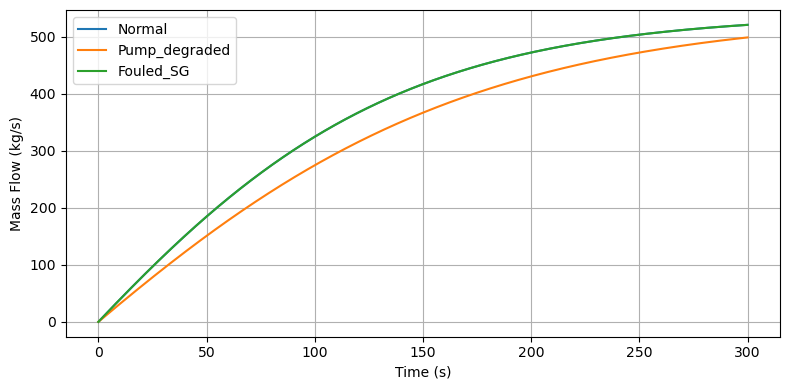

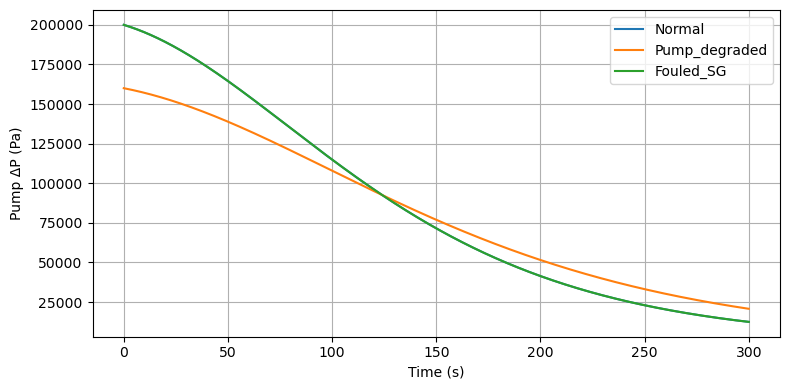

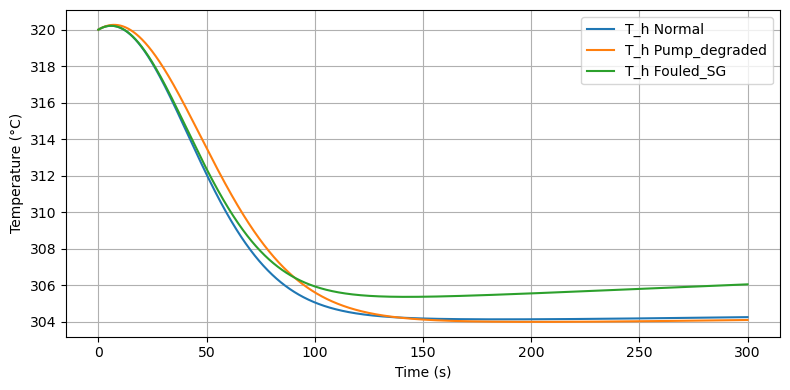

In [4]:
results = {}
for name, params in cases.items():
    t, Th, Tc, md, dPp, dPl = simulate_dynamic(params, dt, t_end, L=L)
    df = pd.DataFrame({
        "time": t, "T_h": Th, "T_c": Tc,
        "mdot": md, "dP_pump": dPp, "dP_loss": dPl
    })
    df.to_csv(OUTDIR / f"assets/primary_loop_dynamic_{name}.csv", index=False)
    results[name] = df

print("CSV exported:",
      [p.name for p in OUTDIR.glob("assets/primary_loop_dynamic_*.csv")])

# Flow
plt.figure(figsize=(8,4))
for name, df in results.items():
    plt.plot(df["time"], df["mdot"], label=name)
plt.xlabel("Time (s)"); plt.ylabel("Mass Flow (kg/s)")
plt.legend(); plt.grid(); plt.tight_layout()
plt.savefig("assets/fig_flow_cases_dynamic.png", dpi=150)
plt.show()

# Pump ΔP
plt.figure(figsize=(8,4))
for name, df in results.items():
    plt.plot(df["time"], df["dP_pump"], label=name)
plt.xlabel("Time (s)"); plt.ylabel("Pump ΔP (Pa)")
plt.legend(); plt.grid(); plt.tight_layout()
plt.savefig("assets/fig_dpump_cases_dynamic.png", dpi=150)
plt.show()

# Temperature (Th only for clarity)
plt.figure(figsize=(8,4))
for name, df in results.items():
    plt.plot(df["time"], df["T_h"], label=f"T_h {name}")
plt.xlabel("Time (s)"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(); plt.tight_layout()
plt.savefig("assets/fig_temperature_dynamic.png", dpi=150)
plt.show()


## 2. Verification — Step-halving (dynamic)

Compare dt and $dt/2$ on **Normal** case, report relative L2 errors for $T_h$ and $\dot m$.


Verification rel L2 — Th: 7.0384e-06, mdot: 6.9592e-05


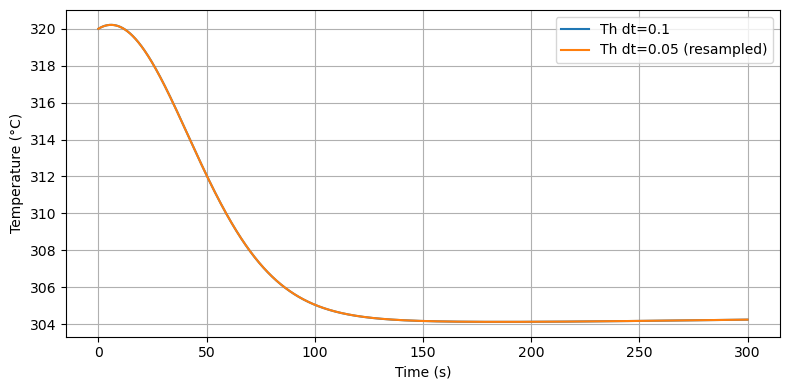

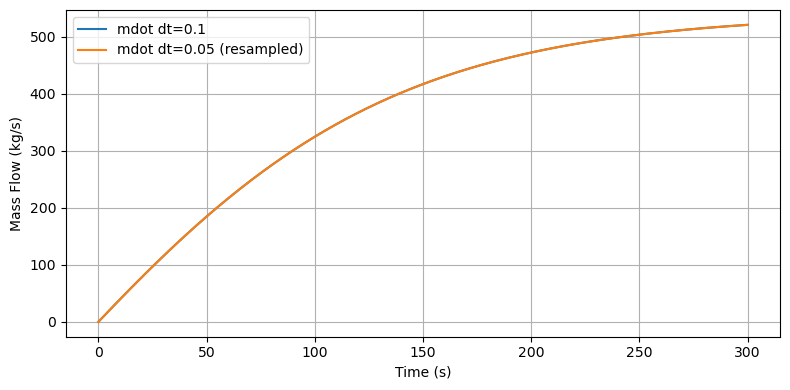

In [5]:
t1, Th1, Tc1, m1, *_ = simulate_dynamic(base, 0.1, t_end, L=L)
t2, Th2, Tc2, m2, *_ = simulate_dynamic(base, 0.05, t_end, L=L)

Th2_rs = Th2[::2]
m2_rs  = m2[::2]

rel_Th = np.linalg.norm(Th1 - Th2_rs) / np.linalg.norm(Th2_rs)
rel_m  = np.linalg.norm(m1  - m2_rs ) / np.linalg.norm(m2_rs)

print(f"Verification rel L2 — Th: {rel_Th:.4e}, mdot: {rel_m:.4e}")

plt.figure(figsize=(8,4))
plt.plot(t1, Th1, label="Th dt=0.1")
plt.plot(t1, Th2_rs, label="Th dt=0.05 (resampled)")
plt.xlabel("Time (s)"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(); plt.tight_layout()
plt.savefig("assets/fig_verification_dynamic_Th.png", dpi=150)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(t1, m1, label="mdot dt=0.1")
plt.plot(t1, m2_rs, label="mdot dt=0.05 (resampled)")
plt.xlabel("Time (s)"); plt.ylabel("Mass Flow (kg/s)")
plt.legend(); plt.grid(); plt.tight_layout()
plt.savefig("assets/fig_verification_dynamic_mdot.png", dpi=150)
plt.show()


## 3. Data Assimilation — EnKF (state = $[T_h, T_c, m_dot]$)
- Observations: temperatures only $(T_h, T_c)$ with Gaussian noise σ
- Process noise: small jitter on $UA$ & $k_{sys}$
- Unobserved m_dot is corrected **indirectly** via coupling


In [6]:
def step_dynamic_state(params, x, dt, L):
    """One Euler step for a single state x=[Th, Tc, mdot] with momentum dynamics."""
    Th, Tc, md = x
    dp_pump = pump_head(md, params["a0"], params["a1"], params["a2"])
    dp_loss = loss_head(md, params["k_sys"])
    dmdt    = (dp_pump - dp_loss) / L
    mdn     = md + dt * dmdt

    QHX = params["UA"] * (Th - params["T_sec"])
    dTh = (md/params["M_h"])*(Tc - Th) + params["Q_core"]/(params["M_h"]*params["cp"])
    dTc = (md/params["M_c"])*(Th - Tc) - QHX/(params["M_c"]*params["cp"])
    Thn = Th + dt * dTh
    Tcn = Tc + dt * dTc
    return np.array([Thn, Tcn, mdn]), dp_pump

def enkf_assim_dynamic(params, L, dt=0.5, t_end=200.0,
                       sigma_T=0.5, N_ens=25, q_noise=0.03, seed=123):
    rng = np.random.default_rng(seed)
    t = np.arange(0.0, t_end + 1e-12, dt)

    # Ensemble init near ICs
    X = np.zeros((3, N_ens))
    X[0, :] = 320.0 + rng.normal(0, 0.2, N_ens)
    X[1, :] = 290.0 + rng.normal(0, 0.2, N_ens)
    X[2, :] = 0.0  # start from 0 flow

    H = np.array([[1,0,0],[0,1,0]])         # observe Th,Tc
    R = (sigma_T**2) * np.eye(2)

    Xf_mean = np.zeros((3, len(t)))
    Xa_mean = np.zeros((3, len(t)))
    Y_meas  = np.zeros((2, len(t)))
    dP_mean = np.zeros(len(t))

    x_truth = np.array([320.0, 290.0, 0.0]) # pseudo-truth from previous analysis

    for i in range(len(t)):
        if i > 0:
            x_truth = Xa_mean[:, i-1]
        y = H @ x_truth + rng.normal(0.0, sigma_T, size=2)
        Y_meas[:, i] = y

        # Forecast with param jitter
        dp_list = []
        for j in range(N_ens):
            p = dict(params)
            p["UA"]    = params["UA"]    * (1.0 + q_noise*rng.normal())
            p["k_sys"] = params["k_sys"] * (1.0 + q_noise*rng.normal())
            X[:, j], dp = step_dynamic_state(p, X[:, j], dt, L)
            dp_list.append(dp)
        dP_mean[i] = float(np.mean(dp_list))

        xbar = X.mean(axis=1, keepdims=True)
        Xf_mean[:, i] = xbar[:, 0]
        Xp = X - xbar
        Pf = (Xp @ Xp.T) / max(1, N_ens-1)

        # Analysis (update Th,Tc; mdot unobserved)
        S = H @ Pf @ H.T + R
        K = Pf @ H.T @ np.linalg.inv(S)
        for j in range(N_ens):
            eps = rng.normal(0.0, sigma_T, size=2)
            innov = (y + eps) - (H @ X[:, j])
            X[:, j] = X[:, j] + K @ innov
        Xa_mean[:, i] = X.mean(axis=1)

    rmse_model = float(np.sqrt(np.mean(np.sum(((H@Xf_mean)-Y_meas)**2, axis=0))))
    rmse_assim = float(np.sqrt(np.mean(np.sum(((H@Xa_mean)-Y_meas)**2, axis=0))))
    return {
        "time": t,
        "Th_model": Xf_mean[0], "Tc_model": Xf_mean[1], "M_model": Xf_mean[2],
        "Th_assim": Xa_mean[0], "Tc_assim": Xa_mean[1], "M_assim": Xa_mean[2],
        "Th_meas": Y_meas[0],   "Tc_meas": Y_meas[1],
        "dP_pump_mean": dP_mean,
        "rmse_model": rmse_model, "rmse_assim": rmse_assim,
        "sigma_T": sigma_T, "N_ens": N_ens, "q_noise": q_noise
    }


EnKF CSV exported: ['primary_loop_dynamic_EnKF_Normal.csv', 'primary_loop_dynamic_EnKF_Fouled_SG.csv', 'primary_loop_dynamic_EnKF_Pump_degraded.csv']
[Normal] RMSE(model)=0.705, RMSE(assim)=0.700
[Pump_degraded] RMSE(model)=0.705, RMSE(assim)=0.700
[Fouled_SG] RMSE(model)=0.705, RMSE(assim)=0.700


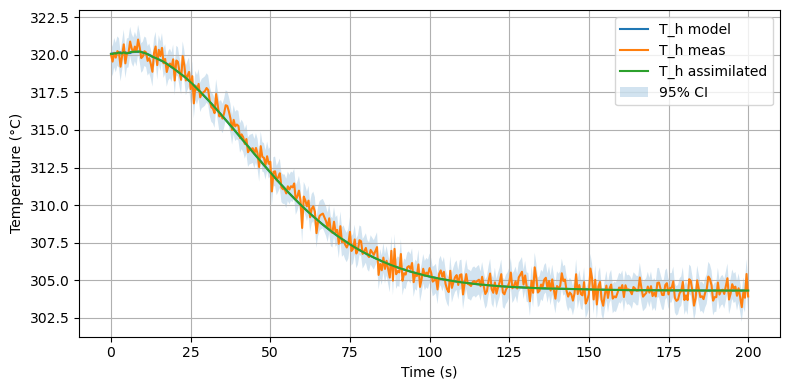

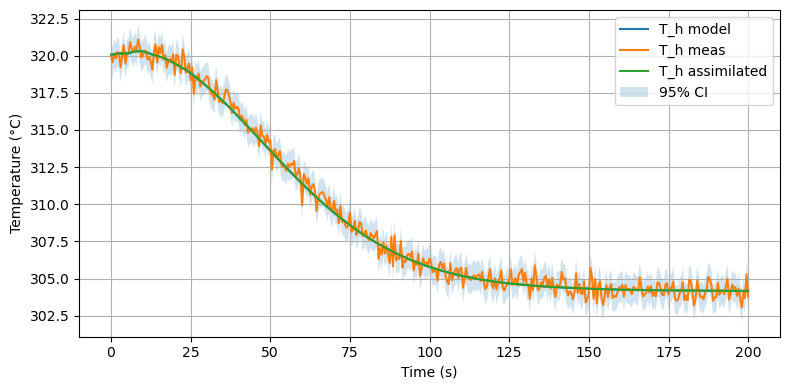

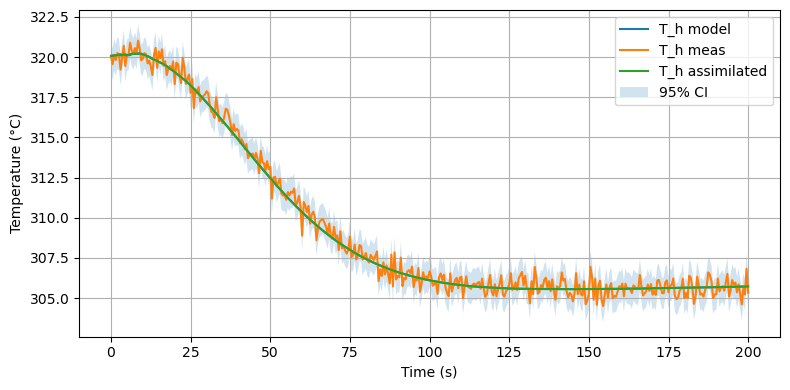

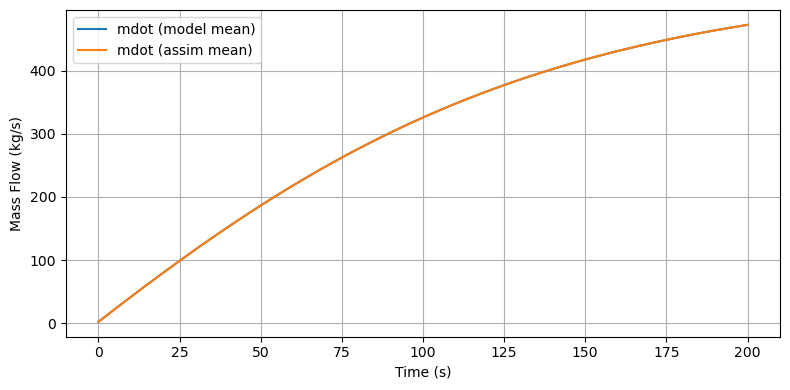

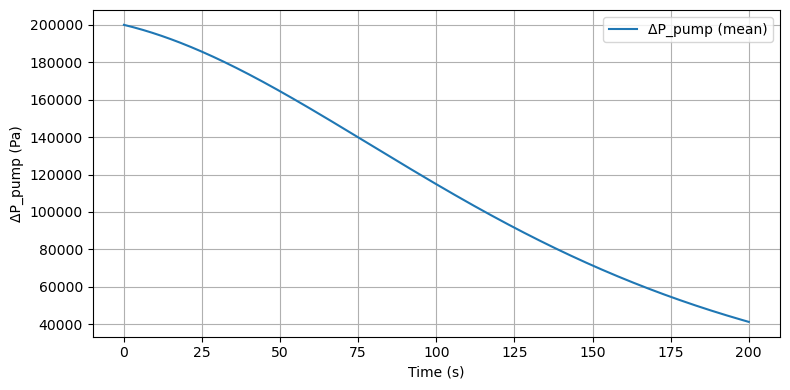

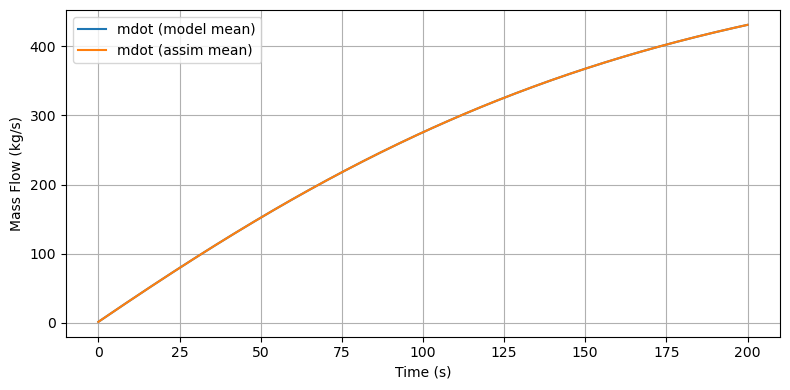

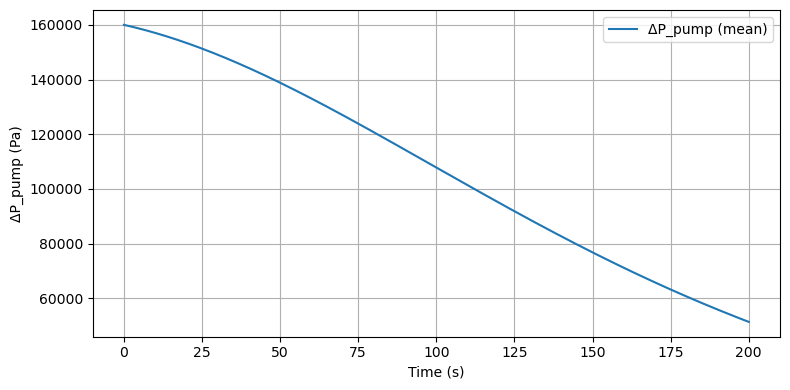

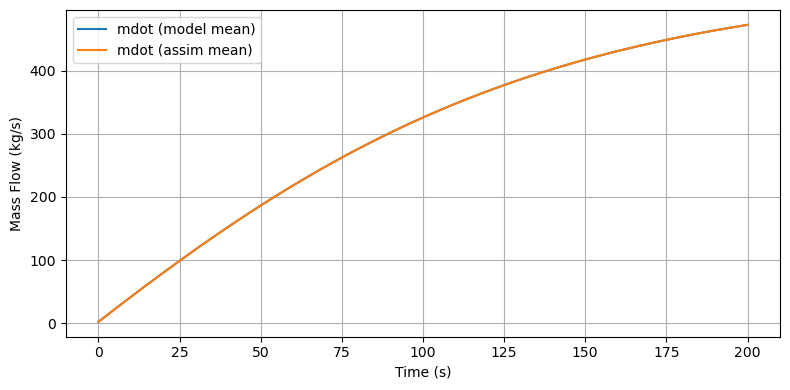

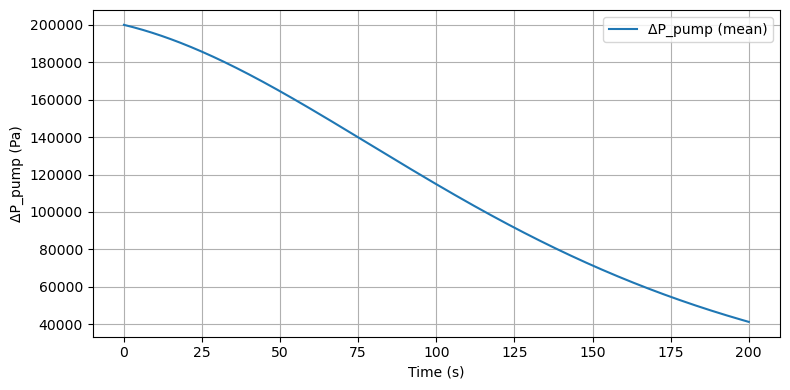

In [7]:
# Settings
L_enkf, dt_enkf, t_end_enkf = 5e4, 0.5, 200.0
sigma_T, N_ens, q_noise = 0.5, 25, 0.03

enkf_out = {}
for name, params in cases.items():
    o = enkf_assim_dynamic(params, L=L_enkf, dt=dt_enkf, t_end=t_end_enkf,
                           sigma_T=sigma_T, N_ens=N_ens, q_noise=q_noise, seed=123)
    enkf_out[name] = o

    # Export CSV
    pd.DataFrame({
        "time": o["time"],
        "T_h_model": o["Th_model"], "T_h_meas": o["Th_meas"], "T_h_assim": o["Th_assim"],
        "T_c_model": o["Tc_model"], "T_c_meas": o["Tc_meas"], "T_c_assim": o["Tc_assim"],
        "mdot_model": o["M_model"],  "mdot_assim": o["M_assim"],
        "dP_pump_mean": o["dP_pump_mean"],
    }).to_csv(f"assets/primary_loop_dynamic_EnKF_{name}.csv", index=False)

print("EnKF CSV exported:",
      [p.name for p in OUTDIR.glob("assets/primary_loop_dynamic_EnKF_*.csv")])

# RMSE summary
for name, o in enkf_out.items():
    print(f"[{name}] RMSE(model)={o['rmse_model']:.3f}, RMSE(assim)={o['rmse_assim']:.3f}")

# Plot T_h assimilation (one plot per scenario)
for name, o in enkf_out.items():
    t = o["time"]
    plt.figure(figsize=(8,4))
    plt.plot(t, o["Th_model"], label="T_h model")
    plt.plot(t, o["Th_meas"],  label="T_h meas")
    plt.plot(t, o["Th_assim"], label="T_h assimilated")
    plt.fill_between(t, o["Th_meas"]-1.96*sigma_T, o["Th_meas"]+1.96*sigma_T, alpha=0.2, label="95% CI")
    plt.xlabel("Time (s)"); plt.ylabel("Temperature (°C)")
    plt.legend(); plt.grid(); plt.tight_layout()
    plt.savefig(f"assets/fig_enkf_dynamic_{name}_Th.png", dpi=150)
    plt.show()

# Optional: flow and ΔP
for name, o in enkf_out.items():
    t = o["time"]
    plt.figure(figsize=(8,4))
    plt.plot(t, o["M_model"], label="mdot (model mean)")
    plt.plot(t, o["M_assim"], label="mdot (assim mean)")
    plt.xlabel("Time (s)"); plt.ylabel("Mass Flow (kg/s)")
    plt.legend(); plt.grid(); plt.tight_layout()
    plt.savefig(f"assets/fig_enkf_dynamic_{name}_mdot.png", dpi=150)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(t, o["dP_pump_mean"], label="ΔP_pump (mean)")
    plt.xlabel("Time (s)"); plt.ylabel("ΔP_pump (Pa)")
    plt.legend(); plt.grid(); plt.tight_layout()
    plt.savefig(f"assets/fig_enkf_dynamic_{name}_dpump.png", dpi=150)
    plt.show()


## 4) Data budget (sensors → rate/volume)

We estimate raw vs edge-feature data rates to argue feasibility and deployment choices.


In [8]:
def data_budget(rows):
    recs = []
    for r in rows:
        rate_Bps = r["count"] * r["freq_hz"] * r["bytes_per_sample"]
        recs.append({
            "Sensor": r["name"], "#": r["count"], "Freq(Hz)": r["freq_hz"],
            "Bytes/sample": r["bytes_per_sample"],
            "Rate(kB/s)": rate_Bps/1024.0,
            "Volume/day(GB)": rate_Bps*86400/1024.0/1024.0/1024.0,
            "Comment": r.get("note","")
        })
    return pd.DataFrame(recs)

raw_rows = [
    {"name":"Thermocouple/RTD", "count":40, "freq_hz":1,   "bytes_per_sample":8,  "note":"Redundant key nodes"},
    {"name":"Pressure Tx",      "count":12, "freq_hz":10,  "bytes_per_sample":8,  "note":"Pump/SG U/D"},
    {"name":"Flowmeter",        "count":4,  "freq_hz":5,   "bytes_per_sample":8,  "note":"Main & branches"},
    {"name":"Accel (raw)",      "count":8,  "freq_hz":2000,"bytes_per_sample":4,  "note":"Bearings"},
    {"name":"Mic (raw)",        "count":4,  "freq_hz":8000,"bytes_per_sample":2,  "note":"Band-limited"},
    {"name":"DCS events",       "count":1,  "freq_hz":1,   "bytes_per_sample":200,"note":"Alarms/States"},
]
edge_rows = raw_rows.copy()
edge_rows[3] = {"name":"Accel (features)","count":8, "freq_hz":200,"bytes_per_sample":16,"note":"1s window features"}
edge_rows[4] = {"name":"Mic (features)",  "count":4, "freq_hz":800,"bytes_per_sample":16,"note":"1s window features"}

df_raw  = data_budget(raw_rows)
df_edge = data_budget(edge_rows)

df_raw.to_csv("assets/data_budget_raw.csv", index=False)
df_edge.to_csv("assets/data_budget_edge.csv", index=False)

display(df_raw)
display(df_edge)


,Sensor,#,Freq(Hz),Bytes/sample,Rate(kB/s),Volume/day(GB),Comment
0,Thermocouple/RTD,40,1,8,0.312500,0.025749,Redundant key nodes
1,Pressure Tx,12,10,8,0.937500,0.077248,Pump/SG U/D
2,Flowmeter,4,5,8,0.156250,0.012875,Main & branches
3,Accel (raw),8,2000,4,62.500000,5.149841,Bearings
4,Mic (raw),4,8000,2,62.500000,5.149841,Band-limited
5,DCS events,1,1,200,0.195312,0.016093,Alarms/States


,Sensor,#,Freq(Hz),Bytes/sample,Rate(kB/s),Volume/day(GB),Comment
0,Thermocouple/RTD,40,1,8,0.312500,0.025749,Redundant key nodes
1,Pressure Tx,12,10,8,0.937500,0.077248,Pump/SG U/D
2,Flowmeter,4,5,8,0.156250,0.012875,Main & branches
3,Accel (features),8,200,16,25.000000,2.059937,1s window features
4,Mic (features),4,800,16,50.000000,4.119873,1s window features
5,DCS events,1,1,200,0.195312,0.016093,Alarms/States


## 5) Performance (edge deploy) & simple CI/CD note

We measure online step time and total runtime for a typical case to justify **edge** feasibility.


In [9]:
t0 = time.perf_counter()
t, Th, Tc, md, dPp, dPl = simulate_dynamic(base, 0.05, 200.0, L=L)
t1 = time.perf_counter()
runtime = t1 - t0
per_step = runtime / len(t)
perf = {"runtime_s": runtime, "steps": int(len(t)), "per_step_s": per_step, "throughput_steps_per_s": 1.0/per_step}
print(json.dumps(perf, indent=2))

with open("assets/performance.json","w") as f:
    json.dump(perf, f, indent=2)


{
  "runtime_s": 0.008528165984898806,
  "steps": 4001,
  "per_step_s": 2.131508619069934e-06,
  "throughput_steps_per_s": 469151.2814226112
}
